In [2]:
import numpy as np, pandas as pd
import os, sys, time, pickle, copy, h5py
import lifelines.utils
import pandas as pd
import optunity
import numpy as np, pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

In [3]:
## set cuda device to 1
os.environ["CUDA_AVAILABLE_DEVICES"] = "1"


In [4]:
def coxreg_single_run(xtr, ytr, penalty):
    '''
    xtr: training data, shape (n_samples, n_features)
    ytr: training label, shape (n_samples, 2), 1st column is status, 2nd column is time
    penalty: penalizer for Cox regression
    
    '''
    df_tr = pd.DataFrame(np.concatenate((ytr, xtr),axis=1))
    df_tr.columns = ['status','time'] + ['X'+str(i+1) for i in range(xtr.shape[1])]
    cph = CoxPHFitter(penalizer=penalty)
    cph.fit(df_tr, duration_col='time', event_col='status')
    
    return cph,df_tr

In [5]:
## use cross validation to select the best penalizer
# 2. 'Hyperparameter' search for Cox Regression model
import optunity
def hypersearch_cox(x_data, y_data, method, nfolds, nevals, penalty_range):
    @optunity.cross_validated(x=x_data, y=y_data, num_folds=nfolds)
    def modelrun(x_train, y_train, x_test, y_test, penalty):
        cvmod,df_tr = coxreg_single_run(xtr=x_train, ytr=y_train, penalty=10 ** penalty)
        cv_preds = cvmod.predict_partial_hazard(x_test)
        cv_C = concordance_index(y_test[:, 1], -cv_preds, y_test[:, 0])
        return cv_C
    optimal_pars, searchlog, _ = optunity.maximize(modelrun, num_evals=nevals,
                                                   solver_name=method, penalty=penalty_range)
    print('Optimal hyperparameters : ' + str(optimal_pars))
    print('Cross-validated C after tuning: %1.3f' % searchlog.optimum)
    return optimal_pars, searchlog

In [6]:
# prepare data for MI-> HF prediction
## load data from model features of subjects which have been correctly predicted as MI classes (true positive)
## get the HF status and time of these subjects [MI-> diagnosis of HF]
## run the Cox regression model and visualize the cph coefficients
prevalent_MI_information_df = pd.read_csv('/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/MI/prevalent_MI.csv')
print(len(prevalent_MI_information_df))
prevalent_MI_information_df.head()


1045


,eid,MI_date,42001-0.0,type,source_code,source,ecg_date,ecg_file_path,cmr_date,cmr_file_path,Genetic sex
0,1007100,2012-10-08,11.0,MI,NaN,NaN,2017-10-6,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,2017-10-06,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,1.0
1,1011223,2017-05-30,11.0,MI,NaN,NaN,2018-4-20,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,2018-04-20,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,1.0
2,1013662,2005-10-11,11.0,MI,NaN,NaN,2015-8-11,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,2015-08-11,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,1.0
3,1025631,2008-06-13,21.0,MI,21.0,Death register and other source(s),2017-10-10,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,2017-10-10,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,1.0
4,1028018,2004-05-26,0.0,MI,NaN,NaN,2015-4-7,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,2015-04-07,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,1.0


In [7]:
## load the HF database:
hf_df = pd.read_csv('/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/HF/HF_record_found_in_algorithmly_defined_I50_ICD10_ICD9_with_source_dates_ecg_cmr_paired.csv')
print(len(hf_df))
hf_df.head()

581


,eid,HF-date,source,i50-source_code,source.1
0,1000532,2018-07-04,40.0,40.0,Hospital admissions data only
1,1010407,2018-09-29,40.0,40.0,Hospital admissions data only
2,1018992,2018-06-06,40.0,40.0,Hospital admissions data only
3,1035896,2019-10-13,40.0,40.0,Hospital admissions data only
4,1054055,2019-08-16,40.0,40.0,Hospital admissions data only


In [8]:
## find time-to-HF for subjects with MI
import pandas as pd
MI_HF_df = pd.merge(prevalent_MI_information_df, hf_df, on='eid', how='inner')
print(len(MI_HF_df))

## eids of subjects with HF already before MI
MI_HF_df['MI_date'] = MI_HF_df['MI_date'].apply(pd.to_datetime).dt.date
MI_HF_df['HF-date'] = MI_HF_df['HF-date'].apply(pd.to_datetime).dt.date
MI_HF_df['ecg_date'] = MI_HF_df['ecg_date'].apply(pd.to_datetime).dt.date

MI_HF_df.head()
HF_after_ECG = MI_HF_df[MI_HF_df['HF-date'] >MI_HF_df['ecg_date']]
HF_before_ECG = MI_HF_df[MI_HF_df['HF-date']<=MI_HF_df['ecg_date']]

print ('find ', len(HF_after_ECG), 'HF after ECG (incident) records')
print ('find ', len(HF_before_ECG), 'HF before ECG (prevalent) records')



171
find  45 HF after ECG (incident) records
find  126 HF before ECG (prevalent) records


/tmp/ipykernel_5645/4192451747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HF_after_ECG['time_to_HF'] = HF_after_ECG['HF-date'] - HF_after_ECG['ecg_date']
/tmp/ipykernel_5645/4192451747.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HF_after_ECG['time_to_HF'] = HF_after_ECG['time_to_HF'].dt.days/30


Text(0, 0.5, 'Number of subjects')

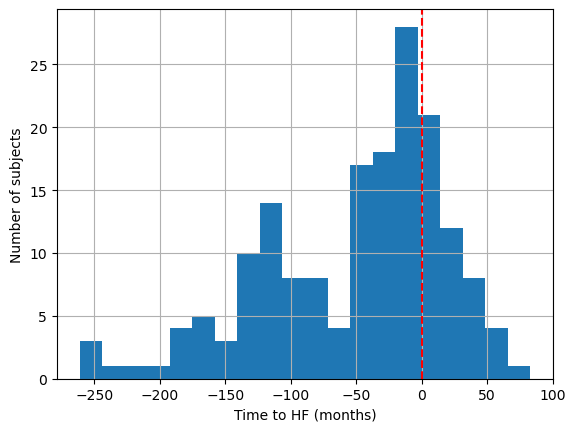

In [17]:
import matplotlib.pyplot as plt
MI_HF_df['time_to_HF'] = MI_HF_df['HF-date'] - MI_HF_df['ecg_date']
# MI_HF_df['time_to_HF'] = HF_after_ECG['time_to_HF'].apply(lambda x: x.days/365)
MI_HF_df['time_to_HF'] = MI_HF_df['time_to_HF'].dt.days/30
HF_after_ECG['time_to_HF'] = HF_after_ECG['HF-date'] - HF_after_ECG['ecg_date']
HF_after_ECG['time_to_HF'] = HF_after_ECG['time_to_HF'].dt.days/30
# MI_HF_df['time_to_HF'] = MI_HF_df['time_to_HF'].apply(lambda x: x.days/30)
plt.axvline(x=0, color='r', linestyle='--')
MI_HF_df['time_to_HF'].hist(bins=20)
plt.xlabel('Time to HF (months)')
plt.ylabel('Number of subjects')

Text(0, 0.5, 'Number of subjects')

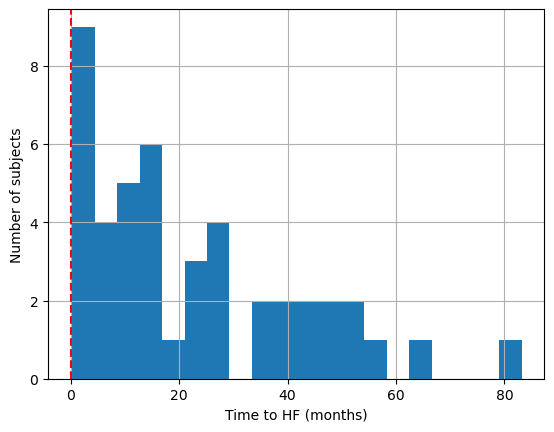

In [18]:
plt.axvline(x=0, color='r', linestyle='--')
HF_after_ECG['time_to_HF'].hist(bins=20)
plt.xlabel('Time to HF (months)')
plt.ylabel('Number of subjects')

In [11]:
HF_after_ECG['time_to_HF'].describe()

count                             45
mean               681 days 11:12:00
std      597 days 22:43:50.895567416
min                  8 days 00:00:00
25%                201 days 00:00:00
50%                465 days 00:00:00
75%               1112 days 00:00:00
max               2495 days 00:00:00
Name: time_to_HF, dtype: object

In [43]:
## exclude subjects with HF before MI
had_MI_HF_df = MI_HF_df[MI_HF_df['time_to_HF']<=0]
prevalent_MI_information_df_filtered = prevalent_MI_information_df[prevalent_MI_information_df.eid.isin(had_MI_HF_df.eid)==False]
print(len(prevalent_MI_information_df_filtered))
prevalent_MI_information_df_filtered.head()

919


,eid,MI_date,42001-0.0,type,source_code,source,ecg_date,ecg_file_path,cmr_date,cmr_file_path
0,1007100,2012-10-08,11.0,MI,NaN,NaN,2017-10-6,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,2017-10-06,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...
1,1011223,2017-05-30,11.0,MI,NaN,NaN,2018-4-20,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,2018-04-20,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...
2,1013662,2005-10-11,11.0,MI,NaN,NaN,2015-8-11,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,2015-08-11,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...
3,1025631,2008-06-13,21.0,MI,21.0,Death register and other source(s),2017-10-10,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,2017-10-10,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...
4,1028018,2004-05-26,0.0,MI,NaN,NaN,2015-4-7,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...,2015-04-07,/mnt/netshare/Biomedia/ibme_biomedia/Projects_...


In [55]:
## compute duration time of follow-up study, censor time is 2023-01-06
censor_time ='2023-01-06'
## convert to datetime
prevalent_MI_information_df_filtered['censor_time'] = censor_time
prevalent_MI_information_df_filtered['censor_time'] = prevalent_MI_information_df_filtered['censor_time'].apply(pd.to_datetime).dt.date
prevalent_MI_information_df_filtered['censor_time']

/tmp/ipykernel_3122464/3511072762.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prevalent_MI_information_df_filtered['censor_time'] = censor_time
/tmp/ipykernel_3122464/3511072762.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prevalent_MI_information_df_filtered['censor_time'] = prevalent_MI_information_df_filtered['censor_time'].apply(pd.to_datetime).dt.date


0       2023-01-06
1       2023-01-06
2       2023-01-06
3       2023-01-06
4       2023-01-06
           ...    
1039    2023-01-06
1041    2023-01-06
1042    2023-01-06
1043    2023-01-06
1044    2023-01-06
Name: censor_time, Length: 919, dtype: object

In [56]:

prevalent_MI_information_df_filtered['ecg_date'] =prevalent_MI_information_df_filtered['ecg_date'].apply(pd.to_datetime).dt.date
# convert to datetime
prevalent_MI_information_df_filtered['HF_status'] = 0
prevalent_MI_information_df_filtered['time_to_HF'] = prevalent_MI_information_df_filtered["censor_time"]-prevalent_MI_information_df_filtered['ecg_date']


/tmp/ipykernel_3122464/117296590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prevalent_MI_information_df_filtered['ecg_date'] =prevalent_MI_information_df_filtered['ecg_date'].apply(pd.to_datetime).dt.date
/tmp/ipykernel_3122464/117296590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prevalent_MI_information_df_filtered['HF_status'] = 0
/tmp/ipykernel_3122464/117296590.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [57]:
## for those subjects who have HF after MI, set HF_status to 1
prevalent_MI_information_df_filtered.loc[prevalent_MI_information_df_filtered.eid.isin(HF_after_ECG.eid), 'HF_status'] = 1
prevalent_MI_information_df_filtered.loc[prevalent_MI_information_df_filtered.eid.isin(HF_after_ECG.eid), 'time_to_HF'] = HF_after_ECG['time_to_HF'].values

In [60]:
## create a new dataframe for Cox regression
## eid, HF_status, time_to_HF
MI_HF_coxreg_df = prevalent_MI_information_df_filtered[['eid','HF_status','time_to_HF']]
MI_HF_coxreg_df.time_to_HF = MI_HF_coxreg_df.time_to_HF.apply(lambda x: int(np.ceil(x.days/7)))
## for the time, we need to convert it to int(weeks)
# MI_HF_coxreg_df['time_to_HF'] = np.ceil(MI_HF_coxreg_df['time_to_HF']/7)
MI_HF_coxreg_df.to_csv('/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/MI/MI_HF_coxreg_df.csv', index=False)
print(len(MI_HF_coxreg_df))
MI_HF_coxreg_df.head(10)

919


/tmp/ipykernel_3122464/725055897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MI_HF_coxreg_df.time_to_HF = MI_HF_coxreg_df.time_to_HF.apply(lambda x: int(np.ceil(x.days/7)))


,eid,HF_status,time_to_HF
0,1007100,0,274
1,1011223,0,246
2,1013662,0,387
3,1025631,0,274
4,1028018,0,405
5,1029628,0,232
6,1030386,0,281
7,1031970,0,395
8,1051753,0,195
9,1058893,0,43


In [61]:
## read the data from the numpy array
stacked_ecg_data_list = np.load("/home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/survival_regression/data/batched_ecg_median_wave_MI_with_HF_event.npy")
eid_list = np.load("/home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/survival_regression/data/e_id_list_MI_with_HF_event.npy")
eid_status_duration_df = pd.read_csv("/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/MI/MI_HF_coxreg_df.csv")
## sort the data by the eid
status_list = []
duration_list = []
for eid in eid_list:
    status = eid_status_duration_df[eid_status_duration_df["eid"]==eid]["HF_status"].values[0]
    duration = eid_status_duration_df[eid_status_duration_df["eid"]==eid]["time_to_HF"].values[0]
    status_list.append(status)
    duration_list.append(duration)
    print(eid, status, duration)

# duration_list

1007100 0 274
1011223 0 246
1013662 0 387
1025631 0 274
1028018 0 405
1029628 0 232
1030386 0 281
1031970 0 395
1051753 0 195
1058893 0 43
1068728 0 246
1083571 0 40
1099680 1 19
1111287 0 417
1114489 1 230
1115857 0 178
1122940 0 228
1137126 1 97
1139805 0 156
1141194 0 417
1144640 0 303
1149675 0 253
1154511 0 188
1155288 0 177
1158107 0 179
1161573 0 185
1167603 0 207
1172140 0 152
1183095 0 223
1198929 0 430
1211080 0 327
1220542 0 292
1222459 0 46
1228276 0 48
1231014 0 252
1243072 0 191
1243394 0 160
1252534 0 46
1259042 0 257
1267586 0 59
1268750 0 203
1275447 0 47
1291919 0 219
1303800 0 186
1308051 0 220
1316483 0 203
1321606 0 252
1321827 0 288
1323544 0 376
1323631 0 425
1332194 0 173
1332235 0 255
1333840 0 250
1346999 0 191
1348100 0 62
1353573 0 348
1358356 0 255
1360063 0 203
1363790 0 424
1364818 0 190
1365240 0 222
1374799 0 303
1375669 0 162
1391556 0 200
1399552 0 399
1401393 0 163
1401911 0 427
1404918 0 312
1405186 0 218
1406927 0 51
1407467 0 369
1408570 0 379
141

In [17]:
MI_HF_coxreg_df.eid.to_csv('/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/MI/MI_HF_coxreg_eid.csv', index=False)

In [18]:
MI_HF_coxreg_df= pd.read_csv('/home/engs2522/project/multi-modal-heart/multi_modal_heart/toolkits/ukb/non_imaging_information/MI/MI_HF_coxreg_df.csv')
MI_HF_coxreg_df.head(5)
# ## make the week to moths
# MI_HF_coxreg_df['time_to_HF'] = np.ceil(MI_HF_coxreg_df['time_to_HF']/4.0)

,eid,HF_status,time_to_HF
0,1007100,0,274
1,1011223,0,246
2,1013662,0,387
3,1025631,0,274
4,1028018,0,405


In [70]:
## load the MI features
model_name ="ECG_attention_pretrained_on_recon_ECG2Text"
# model_name = 'resnet1d101_512+benchmark_classifier_ms_resnet'
model_name = 'resnet1d101_512+benchmark_classifier_ms_resnet_finetune_ECG2Text'
model_name = 'ECG_attention_512_finetuned_no_attention_pool_no_linear_ms_resnet_ECG2Text'
model_name ="resnet1d101_512_pretrained_recon+ECG2Text"
feature = np.load(f'/home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/{model_name}/feature/test_last_hidden_feature.npy')
eid_list = np.load(f'/home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/{model_name}/feature/test_eid.npy')
print(feature.shape)
mi_hf_eid_list = MI_HF_coxreg_df.eid.apply(str).values.tolist()
print(len(mi_hf_eid_list))
print
## find the features of subjects with eids in the MI_HF_coxreg_df
filtered_feature ={}
eid_list = list(set(eid_list))
print(len(eid_list))
for eid,feature_i in zip(eid_list, feature):
    if str(eid) in mi_hf_eid_list:
        filtered_feature[eid] = feature_i
    else:
        continue
        # print(f'{eid_list[i]} not found')
print(len(filtered_feature))

(2089, 128)
919
2085
919


In [71]:
## convert the filtered feature dict to dataframem with eid as index, feature as columns

filtered_feature_df = pd.DataFrame.from_dict(filtered_feature, orient='index')
## for each value , compute the sigmoid value
# filtered_feature_df = filtered_feature_df.apply(lambda x: 1/(1+np.exp(-x)))
filtered_feature_df.index.name = 'eid'  
filtered_feature_df.reset_index(inplace=True)
filtered_feature_df.head()

,eid,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,5160961,1.359448,-0.655349,-0.708142,0.579111,-0.612542,-0.645946,-0.604604,1.461064,-0.387645,...,-0.647443,-0.646164,1.124804,2.910783,-0.717814,0.709324,0.962209,-0.651996,1.397743,-0.226212
1,5365761,-0.709841,3.471670,2.531775,0.036647,2.073291,-0.024168,-0.604604,-0.650890,1.103240,...,0.640247,-0.207659,-0.081990,-0.675553,-0.717814,-0.630059,-0.662096,1.348344,-0.626867,0.922979
2,3334165,-0.497678,-0.655349,-0.708142,-0.749895,-0.612542,-0.409030,-0.604604,-0.650890,-0.622572,...,0.097211,-0.009609,-0.124164,-0.675553,-0.717814,1.689835,-0.158312,-0.651996,-0.680619,0.157431
3,2449438,-0.709841,-0.655349,-0.708142,-0.749895,-0.612542,-0.645946,0.223028,0.270584,1.242434,...,-0.647443,-0.646164,2.566104,0.399865,-0.717814,1.278797,1.847670,1.300148,-0.680619,-0.653985
4,4685865,1.255154,1.100831,-0.708142,-0.749895,-0.612542,-0.645946,-0.604604,-0.650890,1.337000,...,0.593614,-0.646164,3.871922,-0.675553,-0.425470,2.609121,-0.662096,-0.651996,-0.680619,-0.653985


In [106]:
## append the features to the MI_HF_coxreg_df
MI_HF_coxreg_df_feature = pd.merge(MI_HF_coxreg_df, filtered_feature_df, on='eid', how='inner')
print(len(MI_HF_coxreg_df_feature))
MI_HF_coxreg_df_feature.head(5)
MI_HF_coxreg_df_feature[MI_HF_coxreg_df_feature.HF_status==1].head(5)

919


,eid,HF_status,time_to_HF,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
12,1099680,1,1641600000000000,-0.709841,-0.655349,1.394333,1.630959,-0.612542,-0.645946,-0.604604,...,-0.647443,-0.646164,0.261020,0.280980,-0.717814,-0.400269,-0.380480,-0.415960,1.108469,-0.653985
14,1114489,1,19847314285714284,-0.709841,-0.655349,0.622240,0.365602,-0.612542,3.054458,-0.604604,...,0.491068,3.767805,-0.659812,-0.045368,-0.717814,-0.046000,-0.662096,-0.651996,-0.039965,-0.653985
17,1137126,1,8331428571428571,-0.709841,-0.655349,-0.388666,-0.749895,-0.612542,-0.645946,0.878780,...,-0.647443,1.185333,2.685206,-0.521781,-0.717814,1.053936,-0.074771,1.000384,-0.680619,-0.653985
81,1461526,1,20279314285714284,-0.709841,-0.655349,0.369987,-0.749895,-0.612542,-0.645946,-0.157665,...,1.217949,-0.646164,-0.659812,0.154667,-0.479209,1.042477,-0.662096,-0.651996,-0.680619,-0.653985
86,1502448,1,1221942857142857,-0.678168,-0.655349,1.155596,-0.749895,2.636812,-0.645946,-0.604604,...,0.464816,0.075150,1.551777,-0.675553,-0.717814,-0.630059,-0.356735,0.988169,-0.201912,-0.514782


In [83]:
## extract items with column 0:127 as features
MI_HF_coxreg_df_feature_only = MI_HF_coxreg_df_feature.iloc[:,3:]
## convert to numpy array
MI_HF_coxreg_df_feature_only = MI_HF_coxreg_df_feature_only.values
## get the state and time to HF as label
MI_HF_coxreg_df_label = MI_HF_coxreg_df_feature.iloc[:,1:3]
MI_HF_coxreg_df_label = MI_HF_coxreg_df_label.values


In [84]:
MI_HF_coxreg_df_feature_only.shape, MI_HF_coxreg_df_label.shape

((919, 128), (919, 2))

## Find optimal hyperparameters for Cox regression model use cross validation to select the best penalizer


In [75]:

opars, osummary = hypersearch_cox(x_data=MI_HF_coxreg_df_feature_only, y_data=MI_HF_coxreg_df_label, method='particle swarm', nfolds=6, nevals=50, penalty_range=[-2,1])

/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: htt

Optimal hyperparameters : {'penalty': -1.514401624487126}
Cross-validated C after tuning: 0.544


### using the optimal hyperparameters to train the model again on the whole dataset

In [20]:
cph,df = coxreg_single_run(MI_HF_coxreg_df_feature_only, MI_HF_coxreg_df_label, penalty=10**opars['penalty'])

NameError: name 'MI_HF_coxreg_df_feature_only' is not defined

In [80]:
opars['penalty']


-1.514401624487126

# compute harrel's concordance index 

In [77]:
predfull = cph.predict_partial_hazard(MI_HF_coxreg_df_feature_only)
C_app = concordance_index(MI_HF_coxreg_df_label[:,1], -predfull, MI_HF_coxreg_df_label[:,0])

print('\n\n==================================================')
print('Apparent concordance index = {0:.4f}'.format(C_app))
print('==================================================\n\n')



Apparent concordance index = 0.8979




In [85]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 919 total observations, 874 right-censored observations>
             duration col = 'time'
                event col = 'status'
                penalizer = 0.03059133116716893
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 919
number of events observed = 45
   partial log-likelihood = -106.61
         time fit was run = 2023-09-08 21:26:39 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
X1         -0.14       0.87       0.17            -0.47             0.20                 0.63                 1.22
X2         -0.07       0.93       0.19            -0.45             0.31                 0.64                 1.37
X3          0.05       1.05       0.20            -0.35             0.45                 0.71                 1.57
X4         -0.02       0.98       0.20            -0.41             0.38                 0.66                 1.47
X5         -0.04       0.96       0.18            -0.39             0.31                 0.67                 1.37
X6          0.06       1.06       0.18            -0.30             0.41                 0.74                 1.51
X7         -0.10       0.91       0.21            -0.51             0.31                 0.60                 1.36
X8         -0.14       0.87       0.18            -0.48             0.21                 0.62                 1.23
X9          0.18       1.20       0.20            -0.21             0.58                 0.81                 1.78
X10        -0.12       0.89       0.20            -0.51             0.27                 0.60                 1.31
X11        -0.10       0.90       0.18            -0.46             0.26                 0.63                 1.29
X12         0.02       1.02       0.19            -0.35             0.40                 0.70                 1.49
X13         0.12       1.12       0.21            -0.29             0.52                 0.75                 1.68
X14        -0.01       0.99       0.19            -0.38             0.36                 0.69                 1.43
X15        -0.10       0.91       0.18            -0.44             0.25                 0.64                 1.28
X16        -0.11       0.89       0.17            -0.45             0.23                 0.64                 1.26
X17        -0.03       0.97       0.17            -0.37             0.31                 0.69                 1.36
X18         0.12       1.13       0.21            -0.29             0.54                 0.75                 1.71
X19        -0.23       0.79       0.18            -0.59             0.12                 0.56                 1.12
X20         0.18       1.20       0.21            -0.23             0.60                 0.79                 1.82
X21        -0.03       0.97       0.18            -0.38             0.33                 0.68                 1.39
X22        -0.04       0.96       0.19            -0.41             0.34                 0.66                 1.40
X23         0.18       1.20       0.19            -0.20             0.56                 0.82                 1.75
X24         0.07       1.07       0.18            -0.29             0.43                 0.75                 1.54
X25        -0.02       0.98       0.18            -0.38             0.34                 0.68                 1.41
X26         0.18       1.20       0.21            -0.24             0.60                 0.79                 1.82
X27         0.06       1.06       0.20            -0.34             0.45                 0.71                 1.57
X28         0.06       1.06       0.19            -0.32             0.44                 0.73                 1.55
X29         0.03       1.03       0.18            -0.32             0.38                 0.73                 1.4

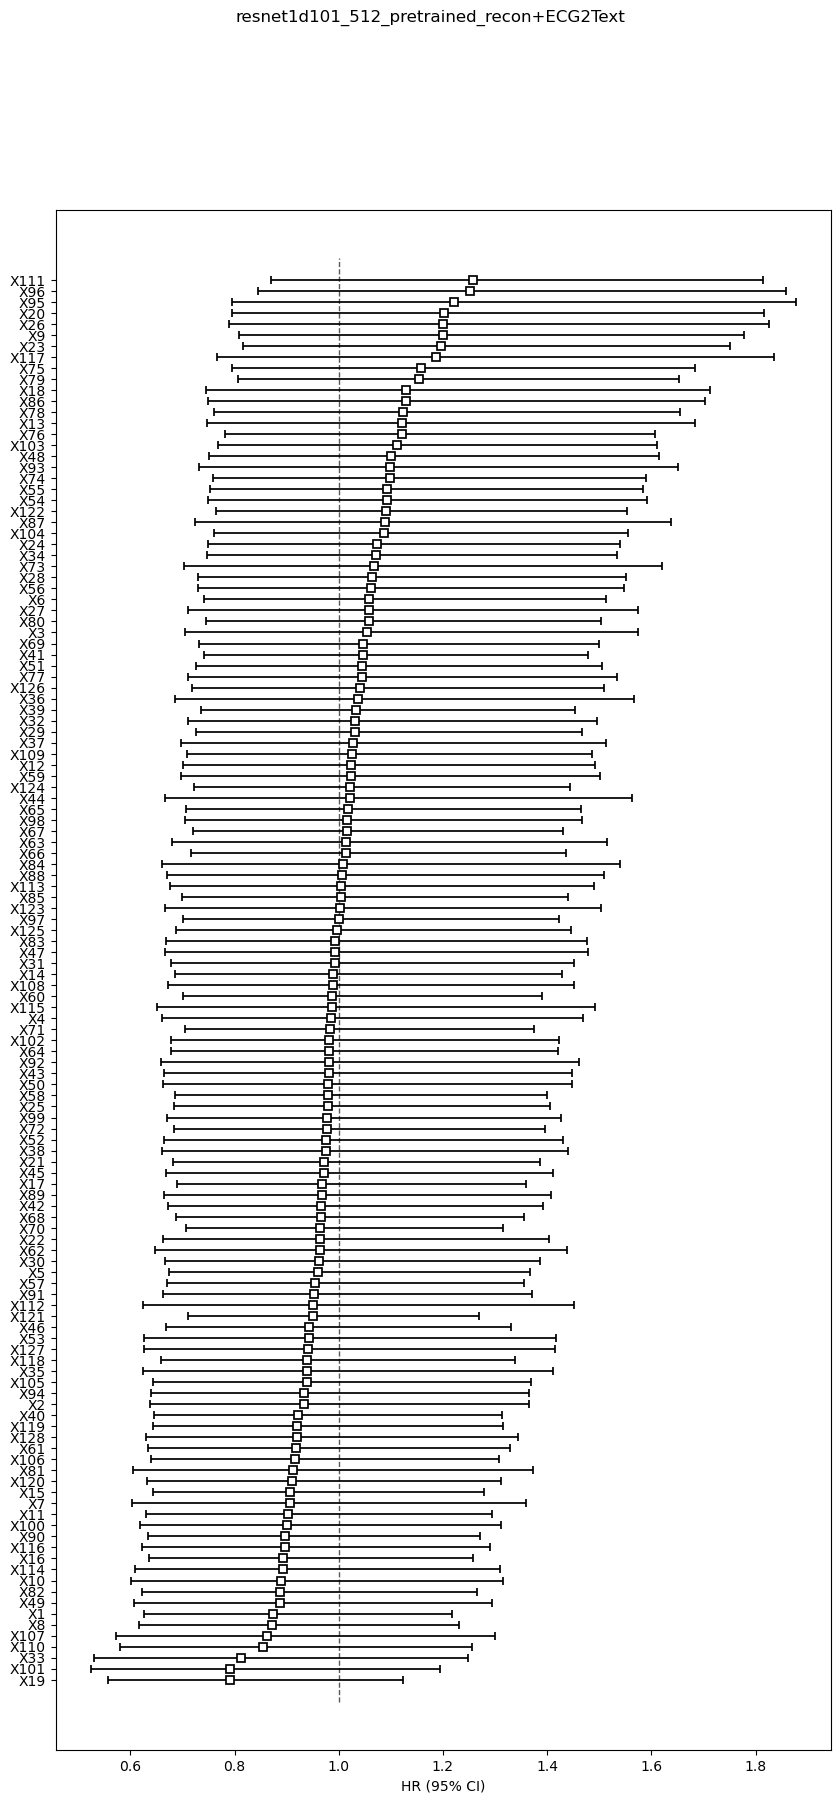

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
cph.plot(hazard_ratios=True)
plt.suptitle(model_name)
plt.savefig(f'/home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/{model_name}/MI_HF_coxreg.png', dpi=300, bbox_inches='tight')


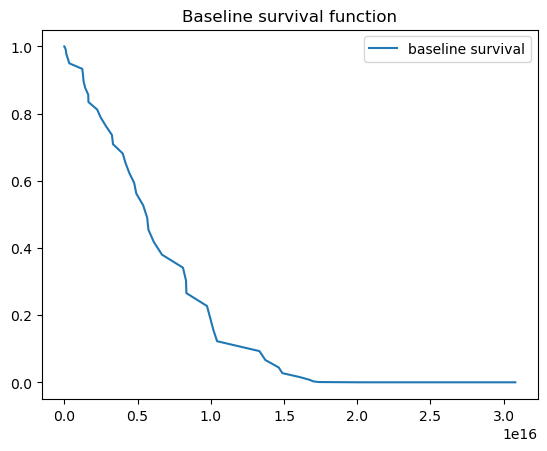

In [93]:
# X = df.loc[0]
# cph.predict_survival_function(X).rename(columns={0:'CoxPHFitter'}).plot()
## plt baseline survival function
cph.baseline_survival_.plot()
plt.title('Baseline survival function')
plt.savefig(f'/home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/{model_name}/baseline_survival_function.png', dpi=300, bbox_inches='tight')


In [ ]:
cph.predict_partial_hazard(X)


0    0.9895
dtype: float64

/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/plotting.py:727: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn("For less visual clutter, you may want to subsample to less than 25 individuals.")


Text(0.5, 0, 'weeks from MI diagnosed')

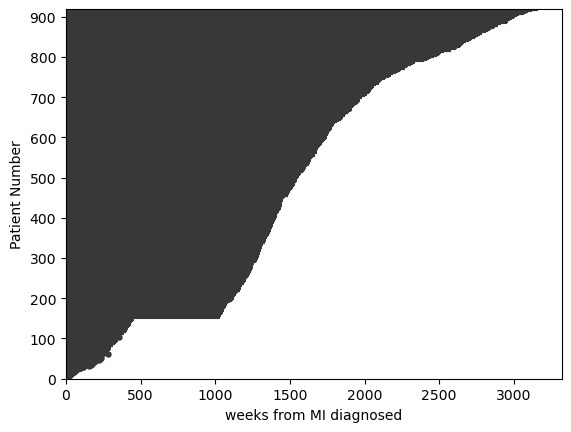

In [ ]:
from lifelines.calibration import survival_probability_calibration
from lifelines.plotting import plot_lifetimes

plot_lifetimes(
    df["time"],
    event_observed=df["status"],
    event_observed_color="#383838",
    event_censored_color="#383838",
    left_truncated=True,
)
plt.ylabel("Patient Number")
plt.xlabel("weeks from MI diagnosed")

In [ ]:
# cph.check_assumptions(df, p_value_threshold=0.05, show_plots=True, plot_n_bootstraps=500)

X111


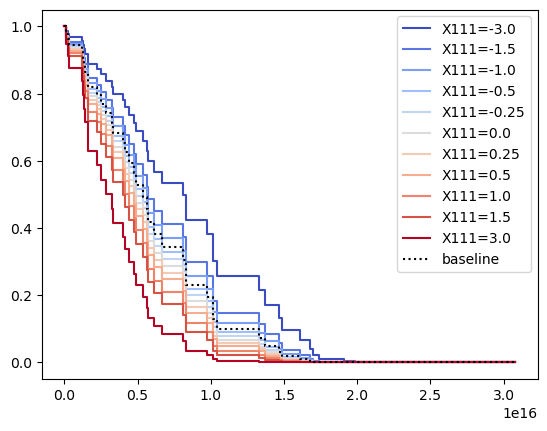

In [103]:
## find the feature with the largest coefficient
id = cph.summary["coef"].sort_values(ascending=False).head(1).index.values[0]
print(id)
cph.plot_partial_effects_on_outcome(covariates=id, values=[-3,-1.5,-1, -0.5, -0.25,0, 0.25,0.5, 1,1.5,3], cmap='coolwarm')
## save the figure
plt.savefig(f'/home/engs2522/project/multi-modal-heart/multi_modal_heart/tasks/finetune_on_MI/{model_name}/partial_effect_on_{id}.png', dpi=300, bbox_inches='tight')

In [ ]:
# from lifelines.utils.sklearn_adapter import sklearn_adapter

# from lifelines import CoxPHFitter
# from lifelines.datasets import load_rossi

# X = MI_HF_coxreg_df_feature[:,2:]# keep as a dataframe
# Y = MI_HF_coxreg_df_feature.iloc[:,2] 

# CoxRegression = sklearn_adapter(CoxPHFitter, event_col='status')
# # CoxRegression is a class like the `LinearRegression` class or `SVC` class in scikit-learn

# sk_cph = CoxRegression(penalizer=1e-5)
# sk_cph.fit(X, Y)
# print(sk_cph)

# """
# SkLearnCoxPHFitter(alpha=0.05, penalizer=1e-5, strata=None, tie_method='Efron')
# """

# sk_cph.predict(X)
# sk_cph.score(X, Y)

## Next we use boostrap sampling to estimate the survival model 

In [104]:
#define useful variables

def bootstrap_survival_model(x_full, y_full, B):
    '''
    This function performs bootstrap resampling on a Cox regression model, to estimate the optimism of the model's C-index.
    Input: 
    x_full: full sample of features, shape (n_samples, n_features)
    y_full: full sample of labels, shape (n_samples, 2), 1st column is status, 2nd column is time
    B: number of bootstrap samples to generate
    Output:
    preds_bootfull: list of predictions on full sample, for each bootstrap sample
    inds_inbag: list of indices of samples in each bootstrap sample
    '''

    nsmp = len(x_full)
    rowids = [_ for _ in range(nsmp)]
    B = 100

    preds_bootfull = []
    inds_inbag = []
    Cb_opts = []
    for b in range(B):
        print('\n-------------------------------------')
        print('Current bootstrap sample:', b, 'of', B-1)
        print('-------------------------------------')

        #STEP 2: Generate a bootstrap sample by doing n random selections with replacement (where n is the sample size)
        b_inds = np.random.choice(rowids, size=nsmp, replace=True)
        xboot = x_full[b_inds]
        yboot = y_full[b_inds]

        #(2a) find optimal hyperparameters
        bpars, bsummary = hypersearch_cox(x_data=xboot, y_data=yboot, method='particle swarm', nfolds=6, nevals=50, penalty_range=[-2,1])
        
        #(2b) using optimal hyperparameters, train a model on bootstrap sample
        bmod, df = coxreg_single_run(xtr=xboot, ytr=yboot, penalty=10**bpars['penalty'])
        
        #(2c[i])  Using bootstrap-trained model, compute predictions on bootstrap sample. Evaluate accuracy of predictions (Harrell's Concordance index)
        predboot = bmod.predict_partial_hazard(xboot)
        Cb_boot = concordance_index(yboot[:,1], -predboot, yboot[:,0])
        
        #(2c[ii]) Using bootstrap-trained model, compute predictions on FULL sample.     Evaluate accuracy of predictions (Harrell's Concordance index)
        predbootfull = bmod.predict_partial_hazard(x_full)
        Cb_full = concordance_index(y_full[:,1], -predbootfull, y_full[:,0])

        #STEP 3: Compute optimism for bth bootstrap sample, as difference between results from 2c[i] and 2c[ii]
        Cb_opt = Cb_boot - Cb_full
    
        #store data on current bootstrap sample (predictions, C-indices)
        preds_bootfull.append(predbootfull)
        inds_inbag.append(b_inds)
        Cb_opts.append(Cb_opt)

        del bpars, bmod
    ## averge the B bootstrap samples
    C_opt = np.mean(Cb_opts)

    return C_opt, Cb_opts, preds_bootfull, inds_inbag


In [107]:
C_opt,  Cb_opts, preds_bootfull, inds_inbag = bootstrap_survival_model(x_full=MI_HF_coxreg_df_feature_only, y_full=MI_HF_coxreg_df_label, B=500)


-------------------------------------
Current bootstrap sample: 0 of 99
-------------------------------------


/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: htt

Optimal hyperparameters : {'penalty': -1.8995703124999999}
Cross-validated C after tuning: 0.707

-------------------------------------
Current bootstrap sample: 1 of 99
-------------------------------------
Optimal hyperparameters : {'penalty': -1.96923828125}
Cross-validated C after tuning: 0.818

-------------------------------------
Current bootstrap sample: 2 of 99
-------------------------------------


/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: htt

Optimal hyperparameters : {'penalty': -1.871070825959621}
Cross-validated C after tuning: 0.633

-------------------------------------
Current bootstrap sample: 3 of 99
-------------------------------------


/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: htt

Optimal hyperparameters : {'penalty': -1.63232421875}
Cross-validated C after tuning: 0.719

-------------------------------------
Current bootstrap sample: 4 of 99
-------------------------------------


/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/engs2522/local/conda/envs/pytorch3d/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: htt

In [ ]:
## print C_app-C_opt
print('C_adj = C_app-C_opt = ', C_app-C_opt)
